In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import auc,roc_curve
import cv2
from PIL import Image
import os
import pandas_profiling
import cufflinks as cf
import plotly.offline
from IPython.core.interactiveshell import InteractiveShell  

InteractiveShell.ast_node_interactivity = "all"
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
data_dir = '../skin-cancer-mnist-ham10000/'
print(os.listdir(data_dir))

['hmnist_28_28_L.csv', '.DS_Store', 'HAM10000_images_part_1.zip', 'HAM10000_images_part_2.zip', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'HAM10000_metadata.csv']


In [4]:
pd.options.display.max_columns = 2400

In [5]:
# Create dataframe and profile raw data
raw_metadata_df = pd.read_csv(data_dir + 'HAM10000_metadata.csv')
pandas_profiling.ProfileReport(raw_metadata_df)

In [6]:
# Save the directory path of HAM10000_images_part_1 and HAM10000_images_part_2
image_part1_dir = '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/'
image_part2_dir = '../skin-cancer-mnist-ham10000/HAM10000_images_part_2/'

In [7]:
# Save the path of the images into their respective lists
image_part_1_list = [image_part1_dir + image_path for image_path in os.listdir(image_part1_dir)]
image_part_2_list = [image_part2_dir + image_path for image_path in os.listdir(image_part2_dir)]


In [80]:
# Merge both lists
all_image_list = list(image_part_1_list + image_part_2_list)
len(all_image_list)
# Check the content of one item in the merged list
all_image_list[1]

10015

'../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028971.jpg'

In [9]:
# Create a dictionnary key : 'name of image' and value : 'file path of image' 
image_dict = {os.path.splitext(os.path.basename(image_path))[0]: image_path for image_path in all_image_list}
len(image_dict) # both the list and dict display the correct total number of images
# Quick check for one element in the dictionnary
image_dict['ISIC_0025030']

10015

'../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025030.jpg'

###### Diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [10]:
# Create dictionary with the diagnostic categories of pigmented lesions
lesion_cat_dict = {
    
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}


In [11]:
# Make a copy of the dataframe as we will be adding new columns
metadata_df = raw_metadata_df.copy()

In [12]:
# Creating New Columns for better readability

metadata_df['file_path'] = metadata_df['image_id'].map(image_dict.get)
metadata_df['category_name'] = metadata_df['dx'].map(lesion_cat_dict.get) 
metadata_df['category_id'] = pd.Categorical(metadata_df['category_name']).codes

In [13]:
# Check for null values
metadata_df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
file_path         0
category_name     0
category_id       0
dtype: int64

In [14]:
# fill age null values by the mean age
metadata_df.age.fillna(metadata_df.age.mean(), inplace=True)

In [15]:
pandas_profiling.ProfileReport(metadata_df)

In [16]:
all_image_list[:10]

['../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026784.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028971.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026948.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026790.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028965.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025299.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024839.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024811.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026960.jpg',
 '../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028795.jpg']

In [21]:
len(all_image_list)

10015

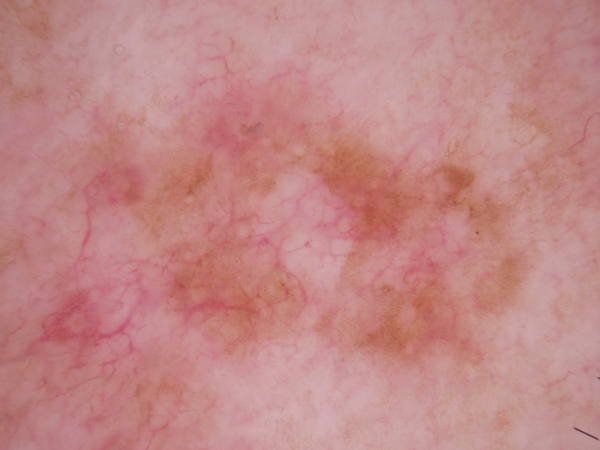

In [17]:
Image.open('../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028795.jpg')

In [18]:
im = Image.open('../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024839.jpg')
im.thumbnail((128,128))
im.show()

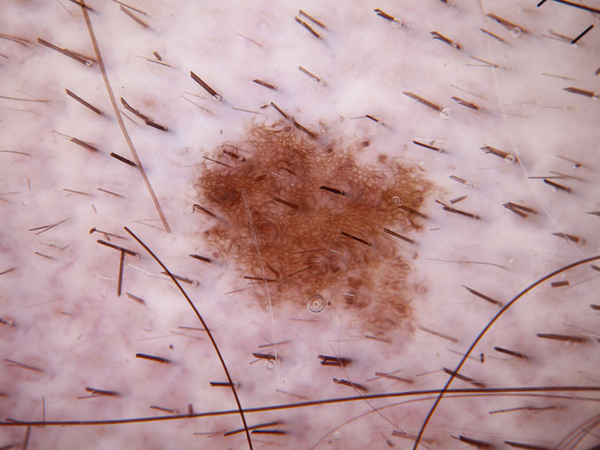

In [40]:
Image.open('../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024839.jpg')

In [2]:
!ls

ISIC_0029307.jpg                      ipynb_tmp
Skin Cancer Classifier Notebook.ipynb


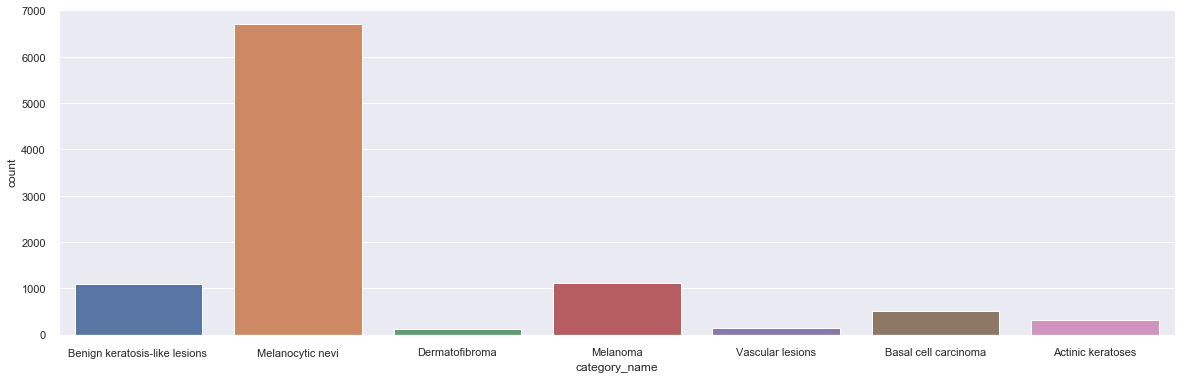

In [101]:
import seaborn as sns
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
sns.countplot(x="category_name", data=metadata_df, ax=ax);

In [ ]:
def copy_images(df, col_name='category_id'):
    n0 = np.ceil(len(df[df['col_name'] == 0].index) * 0.6)
    n1 = np.ceil(len(df[df['col_name'] == 1].index) * 0.6)
    n2 = np.ceil(len(df[df['col_name'] == 2].index) * 0.6)
    n3 = np.ceil(len(df[df['col_name'] == 3].index) * 0.6)
    n4 = np.ceil(len(df[df['col_name'] == 4].index) * 0.6)
    n5 = np.ceil(len(df[df['col_name'] == 5].index) * 0.6)
    n6 = np.ceil(len(df[df['col_name'] == 6].index) * 0.6)
    
    indices = np.random.choice(list(df[df[col_name] == 2].index), int(n0))
    train_cat_2 = df[np.isin(df.index, indices)].reset_index()
    test_cat_2 = df[~np.isin(df.index, indices)].reset_index()
    train_destination = '/Users/basselhaidar/Desktop/Final Project/train_dir'
    test_destination = '/Users/basselhaidar/Desktop/Final Project/test_dir'
    valid_destination = '/Users/basselhaidar/Desktop/Final Project/valid_dir'
    
    for row in range(train_cat_2.shape[0]):
    copy2(train_cat_2.loc[row, 'file_path'], train_destination)

In [30]:
n_train = np.ceil(len(metadata_df[metadata_df['category_id'] == 2].index) * 0.8)

In [79]:
list(metadata_df[metadata_df['category_id'] == 2].index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,

In [39]:
indices = np.random.choice(list(metadata_df[metadata_df['category_id'] == 2].index), int(n_train))

In [52]:
train_cat_2 = metadata_df[np.isin(metadata_df.index, indices)].reset_index()

In [73]:
test_cat_2 = metadata_df[~np.isin(metadata_df.index, indices)].reset_index()

In [50]:
train_cat_2.loc[2,'file_path']

'../skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg'

In [67]:
from shutil import copy2

# copyfile(src, dst)

In [54]:
!mkdir train_dir

In [71]:
train_destination = '/Users/basselhaidar/Desktop/Final Project/train_dir'

In [69]:
copy2('/Users/basselhaidar/Desktop/Final Project/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026769.jpg', )




'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026769.jpg'

In [72]:
for row in range(train_cat_2.shape[0]):
    copy2(train_cat_2.loc[row, 'file_path'], train_destination)

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026769.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029176.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029068.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025209.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029396.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025767.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031326.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025915.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031029.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029836.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032343.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025033.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032128.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027828.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030698.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025567.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031753.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026835.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031159.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031017.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024324.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029559.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027053.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031650.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025076.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025819.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032013.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031691.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025419.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025016.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029147.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027960.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026955.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028052.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025286.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030926.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026104.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025099.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031967.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025140.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029912.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033539.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032283.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026532.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024832.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026958.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030768.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029837.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030607.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029060.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029308.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029425.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028774.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027023.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025388.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028080.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025063.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025548.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032304.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031639.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031212.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032382.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029674.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028607.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024623.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029418.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025906.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034318.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032972.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032534.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033785.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033184.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032929.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032963.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032949.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033127.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033361.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032778.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033466.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029683.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033201.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032514.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033910.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032556.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033592.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032618.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033716.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032877.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034175.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033523.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033761.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033280.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033284.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033908.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033400.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033437.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032553.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033736.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033378.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033379.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032983.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034024.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032863.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033582.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033410.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032725.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033264.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032883.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032665.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033321.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034189.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033306.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032757.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032508.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033828.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034070.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034115.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026107.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033453.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033659.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032567.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033088.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032654.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032576.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033587.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032675.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032997.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033529.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033581.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033913.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034303.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034031.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033124.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032898.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033758.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034113.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033507.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034259.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033446.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033200.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029472.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029682.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033486.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034003.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033629.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034037.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032876.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033635.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033060.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029014.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032215.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030124.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025157.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031376.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031876.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031620.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029548.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025136.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027652.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027218.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030705.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030272.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028020.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032063.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027713.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026060.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026298.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031989.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025777.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026844.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026827.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027680.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025885.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029003.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024711.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032280.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025982.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028120.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025326.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024890.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025507.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025838.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027780.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024592.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030721.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027068.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032168.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024708.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024505.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025743.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027796.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025337.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027037.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032486.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027649.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026607.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030731.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028233.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024971.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025485.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025874.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026728.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031812.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025842.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030706.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031424.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029770.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030227.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028856.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027026.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030095.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031394.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026775.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024773.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032200.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028846.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026159.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028952.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032156.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030783.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029100.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024494.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024445.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031766.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030258.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025297.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027606.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025703.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032051.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026443.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032481.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029776.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027996.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024453.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029519.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025985.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026861.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025830.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031686.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030208.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032006.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028920.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030723.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029217.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028254.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031591.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025275.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029108.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028473.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025529.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026481.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030007.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030812.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027969.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031770.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029557.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026661.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032123.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029166.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026018.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029789.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030026.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031851.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024880.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025659.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026679.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029474.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031016.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026044.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027706.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027801.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030346.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026526.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029991.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028100.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024422.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032043.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030806.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028388.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027806.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025575.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024547.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024758.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030636.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027760.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024760.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029897.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029596.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027527.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031078.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031464.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025693.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027451.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030329.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029311.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024893.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029031.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024772.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026219.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031061.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025973.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025086.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026895.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025716.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024471.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029878.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031289.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030172.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031580.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028389.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028750.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027355.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026787.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026245.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028043.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028640.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026378.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030188.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027437.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026614.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024477.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029678.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031937.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029585.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027990.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026290.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031050.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024997.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024761.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030876.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028702.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026843.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025519.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030319.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031783.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030137.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026947.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031808.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026316.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028104.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030458.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027470.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031522.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024910.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026675.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026335.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032024.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032235.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027916.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025374.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031961.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030533.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032456.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028656.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031716.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029080.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027973.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024495.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028710.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027893.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027982.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030318.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030849.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032358.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029101.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024612.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031707.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030081.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027681.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029243.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030988.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024336.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026704.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028995.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031951.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030310.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029040.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031181.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031287.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026139.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024338.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028229.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030372.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025083.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027017.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029849.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028943.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024312.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030976.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024871.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028830.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028376.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026576.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027504.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025345.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031980.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024881.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028628.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027509.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028414.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030240.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026871.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028451.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026663.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025066.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028236.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029329.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025113.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031261.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029612.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029443.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027239.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028124.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029115.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030700.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028165.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025623.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031831.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027770.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024709.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027354.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027388.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030241.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028931.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030605.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031000.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024786.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029029.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030130.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027392.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031037.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025038.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029102.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030383.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025465.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024489.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026276.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027435.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028180.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032395.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032031.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031872.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028662.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031349.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030835.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027811.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029232.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026249.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026803.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027737.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026248.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027194.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026016.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029505.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025378.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030394.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026524.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027608.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027270.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031853.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028615.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030369.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031600.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024382.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029527.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032111.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031987.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028623.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026631.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024490.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025103.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025710.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028094.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025466.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029931.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029872.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029135.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029270.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030998.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029235.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027826.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026351.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029320.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026530.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024915.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029061.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031893.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028258.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027083.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029555.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027831.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024602.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028479.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024770.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028209.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028449.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028123.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026717.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025810.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030173.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026174.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032170.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025851.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028347.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033722.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033199.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032719.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030630.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032179.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031428.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032315.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028411.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032681.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033509.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032694.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034197.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034057.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033260.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032827.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033022.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033480.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033185.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033924.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032636.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033270.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033865.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034296.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033156.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033701.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033854.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033884.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034142.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033784.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033307.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033987.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033553.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033855.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033660.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034221.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033945.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034280.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033391.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033685.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033490.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032740.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034186.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034252.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026511.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032271.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027142.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031897.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027747.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031253.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029202.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031396.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031196.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024337.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027370.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026566.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028681.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0024383.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032124.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029793.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031133.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030959.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029251.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026046.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029107.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031511.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028587.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026291.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026422.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030316.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028497.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029345.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026846.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026441.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028448.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028503.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031226.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0032460.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027041.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030088.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026959.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027167.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028525.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027954.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031088.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025758.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025856.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031577.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025804.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030207.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026967.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031223.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028958.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025454.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025879.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027428.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026446.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026262.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026416.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029048.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025431.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027332.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026556.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0031362.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026941.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025387.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027027.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0029880.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0025484.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030583.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0026042.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028797.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0027326.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0030789.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0028977.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0033620.jpg'

'/Users/basselhaidar/Desktop/Final Project/train_dir/ISIC_0034040.jpg'

In [94]:
metadata_df.category_name.value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: category_name, dtype: int64

In [19]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [20]:
# # directory path
# train_data_dir = 'data/train'
# test_data_dir = 'data/validation'

# get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        image_part1_dir, 
        target_size=(450, 600), batch_size=64)

# get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        image_part2_dir, 
        target_size=(450, 600), batch_size=32)

# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
